In [1]:
from graph2mat4abn.tools.import_utils import load_config, get_object_from_module
from graph2mat4abn.tools.tools import get_basis_from_structures_paths, get_kwargs, load_model
from graph2mat4abn.tools.scripts_utils import get_model_dataset, init_mace_g2m_model
from graph2mat4abn.tools.script_plots import update_loss_plots, plot_grad_norms
from torch_geometric.data import DataLoader
from graph2mat4abn.tools.scripts_utils import generate_g2m_dataset_from_paths
from graph2mat4abn.tools.notebook_utils import add_dotdot_to_str
from pathlib import Path
from mace.modules import MACE, RealAgnosticResidualInteractionBlock
from graph2mat.models import MatrixMACE
from graph2mat.bindings.e3nn import E3nnGraph2Mat
import torch
import warnings
from graph2mat import BasisTableWithEdges

warnings.filterwarnings("ignore", message="The TorchScript type system doesn't support")
warnings.filterwarnings("ignore", message=".*is not a known matrix type key.*")

from joblib import dump, load
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import sisl
import pickle

def save_pickle(obj, path):
    with open(path, "wb") as f:
        pickle.dump(obj, f)

def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

/home/ICN2/alapena/miniconda3/envs/graph2mat_upt/lib/python3.12/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indic

cuequivariance or cuequivariance_torch is not available. Cuequivariance acceleration will be disabled.


In [ ]:
# Load model, generate prediction and save it (so that we don't have to load the model again and again)

# Select the model to evaluate
model_dir = Path("../results/block_type_mse_nonzero_globalsquarenorm_1e-3_2-8ATOMS") 
model_name = "checkpoints/model_epoch_50000.tar"

# Structure
paths = [
    Path('../dataset/SHARE_OUTPUTS_2_ATOMS/52b6-d4b4-4aa1-bf10-8c7d44c978d3'),
]

# Directory to save the results
split = Path(model_name).parts[0].split("_")[0]
savedir = Path(f"../a-plots/{model_dir.parts[-1]}_{split}")

In [6]:
config = load_config(model_dir / "config.yaml")

# Basis generation (needed to initialize the model)
train_paths, val_paths = get_model_dataset(model_dir, verbose=False)

# We have to add "../" to the relative paths because we are in notebooks/
train_paths = [Path(add_dotdot_to_str(p)) for p in train_paths]
val_paths = [Path(add_dotdot_to_str(p)) for p in val_paths]

paths_basis = train_paths + val_paths
basis = get_basis_from_structures_paths(paths_basis, verbose=True, num_unique_z=config["dataset"].get("num_unique_z", None))
table = BasisTableWithEdges(basis)

print("Initializing model...")
model, optimizer, lr_scheduler, loss_fn = init_mace_g2m_model(config, table)

# Load the model
model_path = model_dir / model_name
model, checkpoint, optimizer, lr_scheduler = load_model(model, optimizer, model_path, lr_scheduler=None, initial_lr=None, device='cpu')
history = checkpoint["history"]
print(f"Loaded model in epoch {checkpoint["epoch"]} with training loss {checkpoint["train_loss"]} and validation loss {checkpoint["val_loss"]}.")

Basis computation.
Number of structures to look on: 582
Looking for unique atoms in each structure...


1it [00:00, 72.80it/s]

Found enough basis points. Breaking the search...
Found enough basis points. Breaking the search...
Found the following atomic numbers: [5, 7]
Corresponding path indices: [0, 0]
Basis with 2 elements built!

Basis for atom 0.
	Atom type: 5
	Basis: ((2, 0, 1), (2, 1, -1), (1, 2, 1))
	Basis convention: siesta_spherical
	R: [3.02420918 2.02341372 3.73961942 3.73961942 3.73961942 2.51253945
 2.51253945 2.51253945 3.73961942 3.73961942 3.73961942 3.73961942
 3.73961942]

Basis for atom 1.
	Atom type: 7
	Basis: ((2, 0, 1), (2, 1, -1), (1, 2, 1))
	Basis convention: siesta_spherical
	R: [2.25704422 1.4271749  2.78012609 2.78012609 2.78012609 1.75309697
 1.75309697 1.75309697 2.78012609 2.78012609 2.78012609 2.78012609
 2.78012609]
Initializing model...



/home/ICN2/alapena/miniconda3/envs/graph2mat_upt/lib/python3.12/site-packages/mace/modules/blocks.py:187: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(atomic_energies, dtype=torch.get_default_dtype()),


Using Optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
LR Scheduler:  ReduceLROnPlateau
Arguments:  None
Keyword arguments:  {'cooldown': 0, 'eps': 0.0, 'factor': 0.9, 'min_lr': 1e-09, 'mode': 'min', 'patience': 100}
LOSS FN SELECTED:  block_type_mse_nonzero_globalsquarenorm
Using Loss function <class 'graph2mat.core.data.metrics.block_type_mse_nonzero_globalsquarenorm'>
Loaded model in epoch 50000 with training loss 486.90899658203125 and validation loss 101211.9375.


In [278]:
for i, path in enumerate(paths):
    
    # Inference
    dataset, processor = generate_g2m_dataset_from_paths(config, basis, table, [path], verbose=False)
    dataloader = DataLoader(dataset, 1)
    model.eval()

    data = next(iter(dataloader))

    with torch.no_grad():
        model_predictions = model(data=data)

        h_pred = processor.matrix_from_data(data, predictions={"node_labels": model_predictions["node_labels"], "edge_labels": model_predictions["edge_labels"]})[0]
        h_true = processor.matrix_from_data(data)[0]

    # Save results
    n_atoms = path.parent.name.split("_")[-2]
    name = f"{n_atoms}atm_{path.name}"
    savedir_result = savedir / name
    savedir_result.mkdir(parents=True, exist_ok=True)

    save_pickle(h_true, savedir_result / "h_true.pkl")
    save_pickle(sisl.get_sile(path / "aiida.HSX").read_geometry(), savedir_result / "geometry.pkl")
    save_pickle(h_pred, savedir_result / "h_pred.pkl")

1it [00:00, 128.73it/s]

Keeping all the dataset in memory.



/home/ICN2/alapena/miniconda3/envs/graph2mat_upt/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning:

'data.DataLoader' is deprecated, use 'loader.DataLoader' instead



In [279]:
# Load the inference
# name = "8atm_11ad-ba95-4a26-8f92-5267f5787553"

loaddir = savedir / name

h_true = load_pickle(loaddir / "h_true.pkl")
geometry = load_pickle(loaddir / "geometry.pkl")
h_pred = load_pickle(loaddir / "h_pred.pkl")
n_atoms = len(geometry.atoms.Z)

In [280]:
# Visualize the structure and hamiltonians
from graph2mat4abn.tools.plot import plot_error_matrices_big

plot_error_matrices_big(h_true.todense(), h_pred.todense())
geometry.plot()

Map the hoppings to each orbital and shift

In [281]:
matrices = [h_true.tocsr().tocoo(), h_pred.tocsr().tocoo()]
n_orbs = 13

to_plot = []
for matrix in matrices:
    # Get energies, shft indices (iscs) and distances
    rows = matrix.row
    cols = matrix.col
    values = matrix.data
    nnz = len(values)

    iscs = []
    orbs_in = []
    orbs_out = []
    energies = []
    for k in range(nnz):
        row = rows[k]
        col = cols[k]

        # if row != col:  # Only add hopping terms for off-diagonal elements

        iscs.append(geometry.o2isc(col))
        orbs_in.append(col % (int(n_atoms)*n_orbs))
        orbs_out.append(row)

        energies.append(values[k])

    # Format conversion
    iscs = np.array(iscs)
    orbs_in = np.array(orbs_in)
    orbs_out = np.array(orbs_out)
    energies = np.array(energies)
        
    # Unique (orbs_in, orbs_out) pairs and their repetitions
    in_out = np.array(list(zip(orbs_in, orbs_out)))
    in_out_unique, in_out_counts = np.unique(in_out, axis=0, return_counts=True)

    in_out_distances = np.ones([in_out_unique.shape[0], in_out_counts.max()], dtype=float)*-1
    in_out_energies = np.ones_like(in_out_distances, dtype=float)*0
    in_out_iscs = np.ones([in_out_unique.shape[0], in_out_counts.max(), 3], dtype=int)*-99

    for k, (orb_in, orb_out) in enumerate(in_out_unique):

        indices = np.where((orbs_in == orb_in) & (orbs_out == orb_out))[0]
        in_out_iscs[k, :len(indices)] = iscs[indices]
        in_out_energies[k, :len(indices)] = energies[indices]
        in_out_distances[k, :len(indices)] = np.linalg.norm(iscs[indices] @ geometry.cell, axis=1)

    to_plot.append((in_out_unique, in_out_iscs, in_out_distances, in_out_energies))


# Plots

Overview using matplotlib

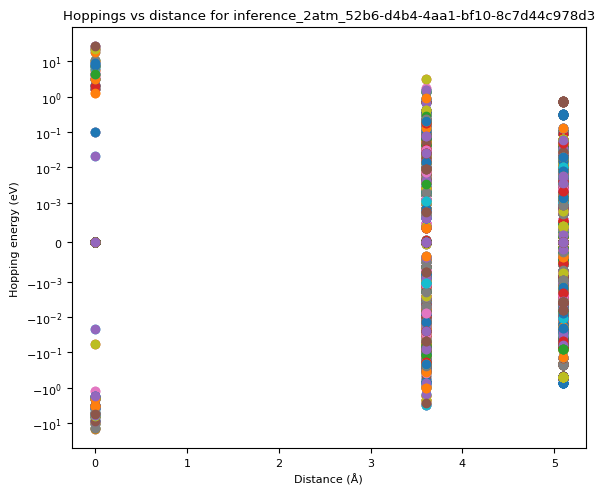

In [12]:
# Plot energies vs distances
plt.figure(figsize=(6, 5))
for k in range(in_out_unique.shape[0]):
    plt.scatter(in_out_distances[k, in_out_distances[k]>=0], in_out_energies[k, in_out_distances[k]>=0], label=f"{in_out_unique[k,0]}->{in_out_unique[k,1]}")
plt.yscale("symlog", linthresh=1e-3)
plt.xlabel("Distance (Å)")
plt.ylabel("Hopping energy (eV)")
plt.title(f"Hoppings vs distance for {name}")
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()

Visualize a specific hopping using plotly

# Build a plotly plot to visualize all hoppings vs dist

In [310]:
import plotly.graph_objects as go
import numpy as np

# in_out_unique contains the hopping orb_in -> orb_out, with the corresponding shift (isc), distances and energies.
# to_plot contains two elements: [0] fro the true hamiltonian, [1] for the predicted.

orb_names_map = {
    0: "s_1",
    1: "s_2",
    2: "py_1",
    3: "pz_1",
    4: "px_1",
    5: "py_2",
    6: "pz_2",
    7: "px_2",
    8: "Pdxy",
    9: "Pdyz",
    10: "Pdz2",
    11: "Pdxz",
    12: "Pdx2-y2",
}
atom_names_map = dict(zip(range(len(geometry.atoms)), [atom.tag for atom in geometry.atoms]))

def plotly_hoppingsvsdist():
    fig = go.Figure()

    # Group by source orbs

    list_orbs_cell = range(n_atoms*n_orbs) # [0, 1, 2, ..., 24, 25] for 2 atm and 13 orbs per atom.

    source_orb_to_traces = []
    trace_index = 0
    for source_orb in list_orbs_cell:
        for j, (in_out_unique, in_out_iscs, in_out_distances, in_out_energies) in enumerate(to_plot):
            # Extract the source orb
            if j == 0:
                mask = in_out_unique[:,0] == source_orb
                orbs = in_out_unique[mask]
                x_true = in_out_distances[mask]
                y_true = in_out_energies[mask]
                z_true = in_out_iscs[mask]
            elif j == 1:
                mask = in_out_unique[:,0] == source_orb
                orbs = in_out_unique[mask]
                x_pred = in_out_distances[mask]
                y_pred = in_out_energies[mask]
                z_pred = in_out_iscs[mask]

        # Map hopping indices to beatiful strings
        orbs_names = np.array([[f"{orb_i} {orb_i//n_orbs}{atom_names_map.get(orb_i//n_orbs)} {orb_names_map.get(orb_i%n_orbs)}", f"{orb_j} {orb_j//n_orbs}{atom_names_map.get(orb_j//n_orbs)} {orb_names_map.get(orb_j%n_orbs)}"] for orb_i, orb_j in orbs])

        # Plot the hoppings, grouped by source orb.
        for destiny in orbs[:,1]:

            group = f"{orbs_names[destiny][0]} → {orbs_names[destiny][1]}"

            error = np.abs(y_true[destiny] - y_pred[destiny])

            name_marker_true=f"{orbs_names[destiny][0]} → {orbs_names[destiny][1]} true"
            fig.add_trace(go.Scatter(
                visible=False,
                x=x_true[destiny],
                y=y_true[destiny],
                mode='markers',
                name=name_marker_true,
                text=[f"{yi:.4f} eV<br>{xi:.2f} Å<br>shift {zi}<br>{name_marker_true}<br>Error: {er:.4f}" for xi, yi, zi, er in zip(x_pred[destiny], y_pred[destiny], z_pred[destiny], error)],
                hoverinfo='text',
                marker=dict(size=6),
                legendgroup=group
            ))

            name_marker_pred = f"{orbs_names[destiny][0]} → {orbs_names[destiny][1]} pred"
            fig.add_trace(go.Scatter(
                visible=False,
                x=x_pred[destiny],
                y=y_pred[destiny],
                mode='markers',
                name=name_marker_pred,
                text=[f"{yi:.4f} eV<br>{xi:.2f} Å<br>shift {zi}<br>{name_marker_pred}<br>Error: {er:.4f}" for xi, yi, zi, er in zip(x_pred[destiny], y_pred[destiny], z_pred[destiny], error)],
                hoverinfo='text',
                marker=dict(size=6),
                legendgroup=group
            ))

            name_marker_err = "error"
            name_marker_err_text = f"{orbs_names[destiny][0]} → {orbs_names[destiny][1]}"
            fig.add_trace(go.Scatter(
                visible=False,
                x=x_true[destiny],
                y=error,
                mode='markers',
                name=name_marker_err,
                text=[f"Error.<br>{yi:.4f} eV<br>{xi:.2f} Å<br>shift {zi}<br>{name_marker_err_text}<br>True: {yi_t:.4f}<br> Pred: {yi_p:.4f}" for xi, yi, zi, yi_t, yi_p in zip(x_true[destiny], error, z_true[destiny], y_true[destiny], y_pred[destiny])],
                hoverinfo='text',
                marker=dict(
                    size=6,
                    symbol='x',
                ),
                legendgroup=group
            ))

        # Create and add slider
        trace_indices = (range(trace_index, n_orbs*n_atoms*3 + trace_index))
        source_orb_to_traces.append(trace_indices)
        trace_index += n_orbs*n_atoms*3

    steps = []
    for trace_indices in source_orb_to_traces:
        visibility = [False] * len(fig.data)
        for idx in trace_indices:
            visibility[idx] = True
        step = dict(
            method="update",
            args=[{"visible": visibility}],
            label=f"{trace_indices[0]//(n_atoms*n_orbs*3)} {trace_indices[0]//(n_atoms*n_orbs*3)//n_orbs}{atom_names_map.get(trace_indices[0]//(n_atoms*n_orbs*3)//n_orbs)} {orb_names_map.get(trace_indices[0]//(n_atoms*n_orbs*3)%n_orbs)}",
        )
        steps.append(step)

    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Source orbital: "},
        pad={"t": 40},
        steps=steps
    )]

    fig.add_shape(
        type="line",
        x0=np.min(x_true)-5,
        x1=np.max(x_true)+5,
        y0=0,
        y1=0,
        line=dict(color="black", width=1,),
        name="E = 0 eV"
    )

    xrange = np.max(x_true) - np.min(x_true)
    margin = 0.05 * xrange
    fig.update_xaxes(
        range=[0-margin, np.max(x_true)+margin],
    )

    fig.update_layout(
        title=f"Hoppings vs distance {name}",
        xaxis_title="Distance (Å)",
        yaxis_title="Hopping energy (eV)",
        width=1200,
        height=500,
        legend=dict(
            x=1.05,
            y=1,
            font=dict(size=10),
            bgcolor='rgba(255,255,255,0.5)',  # Optional: semi-transparent background
            bordercolor='black',
            borderwidth=1
        ),
        margin=dict(l=70, r=150, t=50, b=50),
        sliders=sliders
    )

    # Initial: visible the first orbital
    for i in range(n_orbs*n_atoms*3):
        fig.data[i].visible = True

    return fig

fig = plotly_hoppingsvsdist()

# fig.show()

filename = f"{name}_model{model_dir.parts[-1]}_{split}_energyvsdist.html"
savedir_plot = savedir_result / "energy vs dist"
savedir_plot.mkdir(parents=True, exist_ok=True)
filepath = savedir_result / "energy vs dist" / filename
fig.write_html(filepath)

Now, as probably this kind of plot is too sized for plotly, let's split each source orbital into different files.

In [311]:
list_orbs_cell = range(n_atoms*n_orbs) # [0, 1, 2, ..., 24, 25] for 2 atm and 13 orbs per atom.

source_orb_to_traces = []
trace_index = 0
for source_orb in list_orbs_cell:
    # New fig per each source orb
    fig = go.Figure()

    for j, (in_out_unique, in_out_iscs, in_out_distances, in_out_energies) in enumerate(to_plot):
        # Extract the source orb
        if j == 0:
            mask = in_out_unique[:,0] == source_orb
            orbs = in_out_unique[mask]
            x_true = in_out_distances[mask]
            y_true = in_out_energies[mask]
            z_true = in_out_iscs[mask]
        elif j == 1:
            mask = in_out_unique[:,0] == source_orb
            orbs = in_out_unique[mask]
            x_pred = in_out_distances[mask]
            y_pred = in_out_energies[mask]
            z_pred = in_out_iscs[mask]

    # Map hopping indices to beatiful strings
    orbs_names = np.array([[f"{orb_i} {orb_i//n_orbs}{atom_names_map.get(orb_i//n_orbs)} {orb_names_map.get(orb_i%n_orbs)}", f"{orb_j} {orb_j//n_orbs}{atom_names_map.get(orb_j//n_orbs)} {orb_names_map.get(orb_j%n_orbs)}"] for orb_i, orb_j in orbs])

    # Plot the hoppings, grouped by source orb.
    for destiny in orbs[:,1]:

        group = f"{orbs_names[destiny][0]} → {orbs_names[destiny][1]}"
        error = np.abs(y_true[destiny] - y_pred[destiny])

        name_marker_true=f"{orbs_names[destiny][0]} → {orbs_names[destiny][1]} true"
        fig.add_trace(go.Scatter(
            x=x_true[destiny],
            y=y_true[destiny],
            mode='markers',
            name=name_marker_true,
            text=[f"{yi:.4f} eV<br>{xi:.2f} Å<br>shift {zi}<br>{name_marker_true}<br>Error: {er:.4f}" for xi, yi, zi, er in zip(x_pred[destiny], y_pred[destiny], z_pred[destiny], error)],
            hoverinfo='text',
            marker=dict(size=6),
            legendgroup=group
        ))

        name_marker_pred = f"{orbs_names[destiny][0]} → {orbs_names[destiny][1]} pred"
        fig.add_trace(go.Scatter(
            x=x_pred[destiny],
            y=y_pred[destiny],
            mode='markers',
            name=name_marker_pred,
            text=[f"{yi:.4f} eV<br>{xi:.2f} Å<br>shift {zi}<br>{name_marker_pred}<br>Error: {er:.4f}" for xi, yi, zi, er in zip(x_pred[destiny], y_pred[destiny], z_pred[destiny], error)],
            hoverinfo='text',
            marker=dict(size=6),
            legendgroup=group
        ))

        name_marker_err = "error"
        name_marker_err_text = f"{orbs_names[destiny][0]} → {orbs_names[destiny][1]}"
        fig.add_trace(go.Scatter(
            x=x_true[destiny],
            y=error,
            mode='markers',
            name=name_marker_err,
            text=[f"Error.<br>{yi:.4f} eV<br>{xi:.2f} Å<br>shift {zi}<br>{name_marker_err_text}<br>True: {yi_t:.4f}<br> Pred: {yi_p:.4f}" for xi, yi, zi, yi_t, yi_p in zip(x_true[destiny], error, z_true[destiny], y_true[destiny], y_pred[destiny])],
            hoverinfo='text',
            marker=dict(
                size=6,
                symbol='x',
            ),
            legendgroup=group
        ))

    fig.add_shape(
        type="line",
        x0=np.min(x_true)-5,
        x1=np.max(x_true)+5,
        y0=0,
        y1=0,
        line=dict(color="black", width=1,),
        name="E = 0 eV"
    )

    xrange = np.max(x_true) - np.min(x_true)
    margin = 0.05 * xrange
    fig.update_xaxes(
        range=[0-margin, np.max(x_true)+margin],
    )

    fig.update_layout(
        title=f"Hoppings vs distance {name}<br>source_orb: {source_orb} {source_orb//n_orbs}{atom_names_map.get(source_orb//n_orbs)} {orb_names_map.get(source_orb%n_orbs)}",
        xaxis_title="Distance (Å)",
        yaxis_title="Hopping energy (eV)",
        width=1200,
        height=500,
        legend=dict(
            x=1.05,
            y=1,
            font=dict(size=10),
            bgcolor='rgba(255,255,255,0.5)',  # Optional: semi-transparent background
            bordercolor='black',
            borderwidth=1
        ),
        margin=dict(l=70, r=150, t=60, b=50),
    )

    filename = f"{name}_model{model_dir.parts[-1]}_{split}_energyvsdist_sourceorb{source_orb}.html"
    savedir_plot = savedir_result / "energy vs dist"
    savedir_plot.mkdir(parents=True, exist_ok=True)
    filepath = savedir_result / "energy vs dist" / filename
    fig.write_html(filepath)

# fig.show()


# Deprecated

In [ ]:
import plotly.graph_objects as go
import numpy as np

k_i = 416*0
k_f = 416*1
k_range = range(k_i,k_f)  # * Choose the index/indices you want to plot

fig = go.Figure()

for j, (in_out_unique, in_out_iscs, in_out_distances, in_out_energies) in enumerate(to_plot):

    if j==0:
        title = "TRUE"
    else:
        title = "PREDICTED"

    for k in k_range:

        mask = in_out_distances[k] >= 0
        x = in_out_distances[k][mask]
        y = in_out_energies[k][mask]
        z = in_out_iscs[k][mask]

        group = f"({in_out_unique[k,0]}, {in_out_unique[k,1]})"

        fig.add_trace(go.Scatter(
            x=x,
            y=y,
            mode='markers',
            name=f"orb {in_out_unique[k,0]} → orb {in_out_unique[k,1]} {title}",  # Unicode arrow for clarity
            text=[f"{yi:.4f} eV<br>{xi:.2f} Å<br>shift {zi}" for xi, yi, zi in zip(x, y, z)],
            hoverinfo='text',
            marker=dict(size=6),
            legendgroup=group
        ))

    fig.add_shape(
        type="line",
        x0=min(x)-5,
        x1=max(x)+5,
        y0=0,
        y1=0,
        line=dict(color="black", width=1,),
        name="E = 0 eV"
    )

    xrange = max(x) - min(x)
    margin = 0.05 * xrange
    fig.update_xaxes(
        range=[0-margin, max(x)+margin],
    )

    fig.update_layout(
        title=f"Hoppings vs distance for {name}",
        xaxis_title="Distance (Å)",
        yaxis_title="Hopping energy (eV)",
        width=1200,
        height=500,
        legend=dict(
            x=1.05,
            y=1,
            font=dict(size=10),
            bgcolor='rgba(255,255,255,0.5)',  # Optional: semi-transparent background
            bordercolor='black',
            borderwidth=1
        ),
        margin=dict(l=50, r=150, t=50, b=50),
    )

filename = f"{name}_model{model_dir.parts[-1]}_{split}_energyvsdist_hoppings{k_range[0]}-{k_range[-1]}.html"
filepath = savedir_result / filename
fig.write_html(filepath)

fig.show()


What if I directly plot the error, instead of the true and predicted?

In [ ]:
from plotly.subplots import make_subplots
from PIL import Image
import base64
from io import BytesIO

def plot_err_vs_dist(k_range):
    fig = make_subplots(rows=1, cols=3, column_widths=[0.15, 0.84, 0.01])

    geometry_fig = geometry.plot()
    geometry_fig.write_image("geometry.png", format="png", width=600, height=500)

    img = Image.open("geometry.png")
    buffered = BytesIO()
    img.save(buffered, format="PNG")
    img_base64 = base64.b64encode(buffered.getvalue()).decode()


    fig.add_layout_image(
        dict(
            source=f"data:image/png;base64,{img_base64}",
            xref="x domain", yref="y domain",
            x=0.0, y=1.0,
            sizex=0.2, sizey=1.0,
            xanchor="left", yanchor="top",
            layer="below"
        )
    )


    in_out_unique = to_plot[0][0]
    in_out_iscs = to_plot[0][1]
    in_out_distances = to_plot[0][2]
    in_out_errors = np.abs(to_plot[0][3] - to_plot[1][3])

    for k in k_range:

        mask = in_out_distances[k] >= 0
        x = in_out_distances[k][mask]
        y = in_out_errors[k][mask]
        z = in_out_iscs[k][mask]

        fig.add_trace(go.Scatter(
            x=x,
            y=y,
            mode='markers',
            name=f"orb {in_out_unique[k,0]} → orb {in_out_unique[k,1]}",  # Unicode arrow for clarity
            text=[f"{yi:.4f} eV<br>{xi:.2f} Å<br>shift {zi}<br>orb {in_out_unique[k,0]} → orb {in_out_unique[k,1]}" for xi, yi, zi in zip(x, y, z)],
            hoverinfo='text',
            marker=dict(size=6),
        ), row=1, col=2)

    fig.add_shape(
        type="line",
        x0=min(x)-5,
        x1=max(x)+5,
        y0=0,
        y1=0,
        line=dict(color="black", width=1,),
        name="E = 0 eV",
        row=1, col=2
    )

    xrange = max(x) - min(x)
    margin = 0.05 * xrange
    fig.update_xaxes(
        range=[0-margin, max(x)+margin],
        row=1, col=2
    )

    fig.update_layout(
        title=f"Error vs distance for {name}",
        xaxis_title="Distance (Å)",
        yaxis_title="Error in the energy (eV)",
        width=1600,
        height=500,
        legend=dict(
            x=0.93,
            y=1,
            font=dict(size=10),
            # bgcolor='rgba(255,255,255,0.5)',  # Optional: semi-transparent background
            # bordercolor='black',
            # borderwidth=1,
        ),
        margin=dict(l=0, r=50, t=50, b=50)
    )

    filename = f"{name}_model{model_dir.parts[-1]}_{split}_errorvsdist_hoppings{k_range[0]}-{k_range[-1]}.html"
    filepath = savedir_result / filename
    fig.write_html(filepath)
    return fig

factor = 4
intervals = int((cols.max()+1)/n_orbs/n_atoms/factor)
for i in range(intervals):
    k_i = n_orbs*n_atoms*factor*i
    k_f = n_orbs*n_atoms*factor*(i+1)
    k_range = range(k_i,k_f)  # * Choose the index/indices you want to plot

    fig = plot_err_vs_dist(k_range)

# Last plot

k_i = n_orbs*n_atoms*factor*i
k_f = int(cols.max()+1)
k_range = range(k_i,k_f)  # * Choose the index/indices you want to plot

fig = plot_err_vs_dist(k_range)

fig.show()

In [ ]:
print(cols[-1])
print(k_i)
print(k_f)
print(k_range)
to_plot[0][2].shape

Interesting: there is more error in the low-mid distance region. Too far means low energy, and the model seems capable to predict that. Most of the problems come between 3-7 Angstroms.

Let's now plot error vs energy.

In [ ]:
# k_range = range(0, int(cols.max()-1))
k_range = range(0, 10816)
fig = go.Figure()

in_out_unique = to_plot[0][0]
in_out_iscs = to_plot[0][1]
in_out_distances = to_plot[0][2]
in_out_energies_true = to_plot[0][3]
in_out_errors = np.abs(to_plot[0][3] - to_plot[1][3])

for k in k_range:

    mask = in_out_distances[k] >= 0
    x = in_out_energies_true[k][mask]
    y = in_out_errors[k][mask]
    z = in_out_iscs[k][mask]

    fig.add_trace(go.Scatter(
        x=x,
        y=y,
        mode='markers',
        name=f"orb {in_out_unique[k,0]} → orb {in_out_unique[k,1]}",  # Unicode arrow for clarity
        text=[f"y = {yi:.4f} eV<br>x = {xi:.2f} eV<br>shift {zi}" for xi, yi, zi in zip(x, y, z)],
        hoverinfo='text',
        marker=dict(size=6),
    ))

fig.add_shape(
    type="line",
    x0=min(x)-5,
    x1=max(x)+5,
    y0=0,
    y1=0,
    line=dict(color="black", width=1,),
    name="E = 0 eV"
)

xrange = max(x) - min(x)
margin = 0.05 * xrange
fig.update_xaxes(
    range=[0-margin, max(x)+margin],
)

fig.update_layout(
    title=f"Error vs energy for {name}",
    xaxis_title="True energy (eV)",
    yaxis_title="Error in the energy (eV)",
    width=1200,
    height=500,
    legend=dict(
        x=1.05,
        y=1,
        font=dict(size=10),
        bgcolor='rgba(255,255,255,0.5)',  # Optional: semi-transparent background
        bordercolor='black',
        borderwidth=1
    ),
    margin=dict(l=50, r=150, t=50, b=50)
)

filename = f"{name}_model{model_dir.parts[-1]}_{split}_errorvsenergy_hoppings{k_range[0]}-{k_range[-1]}.html"
filepath = savedir_result / filename
fig.write_html(filepath)

fig.show()

I don't see an energy region with more error. It seems, instead, that the error is "homogeneous" for all energies.

I had a nice idea. Let's plot a 2D histogram of the errors vs true energy and distance (a mesh).

In [ ]:
# ! Work in progress...

# Bands

In [ ]:
import numpy as np

def get_reciprocal_cell(cell):
    """
    Calculate the reciprocal lattice vectors from a real-space lattice.

    Parameters:
    cell (ndarray): 3x3 array representing the real-space lattice vectors as rows.

    Returns:
    ndarray: 3x3 array of reciprocal lattice vectors as rows.
    """
    volume = np.dot(cell[0], np.cross(cell[1], cell[2]))
    reciprocal_cell = 2 * np.pi * np.linalg.inv(cell).T
    return reciprocal_cell

def gen_kpath(k_cart, n):
    k_path = []
    segments = []
    for i in range(len(k_cart) - 1):
        start = k_cart[i]
        end = k_cart[i + 1]
        segment = np.linspace(start, end, n, endpoint=False)
        k_path.extend(segment)
    k_path.append(k_cart[-1])

    k_idx = [i * n for i in range(len(k_cart))]
    return np.array(k_path), k_idx, 

def gen_kdist(kpath):
    kpath = np.asarray(kpath)
    diffs = np.diff(kpath, axis=0)
    distances = np.concatenate(([0], np.cumsum(np.linalg.norm(diffs, axis=1))))
    return distances


In [ ]:
import scipy
from tqdm import tqdm
from graph2mat4abn.tools.tools import reconstruct_tim_from_coo, reduced_coord

file = sisl.get_sile(path / "aiida.HSX")
cell = geometry.cell

# Define a path in k-space

b1, b2, b3 = get_reciprocal_cell(cell) # Angstrom^-1
# k_pos_frac, k_pos_cart = real_space_to_kspace(positions, b1, b2, b3)

# Compute k path (not definitive to use in the report)
B = np.vstack([b1, b2, b3])  # shape (3,3)

# # For Molecules:
# k_cart = np.array([[0.0, 0.0, 0.0], b1, b2, b3])
# k_label = ['Γ', "X", "Y", "Z"]

# For cubic:
# High-symmetry points in fractional coords (relative to b1, b2, b3)
frac_kpts = np.array([
    [0.0, 0.0, 0.0],  # Γ
    [0.0, 0.5, 0.0],  # X
    [0.5, 0.5, 0.0],  # M
    [0.0, 0.0, 0.0],  # Γ
    [0.5, 0.5, 0.5],  # R
    [0.0, 0.5, 0.0],  # X
    [0.5, 0.5, 0.0],  # M
    [0.5, 0.0, 0.0],  # X1
])
k_cart = frac_kpts @ np.array([b1, b2, b3])
k_label = ['Γ', 'X', 'M', 'Γ', 'R', 'X', 'M', 'X1']

# # Physical hBN
# # High-symmetry points in fractional coords (relative to b1, b2, b3)
# frac_kpts = np.array([
#     [0.0,         0.0,         0.0],  # Γ
#     [0.5,         0.0,         0.0],  # M
#     [1/3,         1/3,         0.0],  # K
#     [0.0,         0.0,         0.0],  # Γ
#     [0.0,         0.0,         0.5],  # A
#     [0.5,         0.0,         0.5],  # L
#     [1/3,         1/3,         0.5],  # H
#     [1/3,         1/3,         0.0],  # K
#     [1/3,         1/3,        -0.5],  # H2
# ])
# k_cart = frac_kpts @ np.array([b1, b2, b3])
# k_label = ['Γ', 'M', 'K', 'Γ', 'A', 'L', 'H', 'K', 'H2']

# # amorphous
# frac_kpts = np.array([
#     [0.0,         0.0,         0.0],  # Γ
#     [1.0,         1.0,         1.0],  # Γ
# ])
# k_cart = frac_kpts @ np.array([b1, b2, b3])
# k_label = ['Γ', 'XYZ']

n_ks = 20
k_path, k_idx = gen_kpath(k_cart, n_ks)
k_len = gen_kdist(k_path)


In [ ]:
# TIM reconstruction

h_uc = file.read_hamiltonian()
s_uc = file.read_overlap()

energy_bands_pred = []
energy_bands_true = []
for k_point in tqdm(k_path):
    # Ground truth:
    Hk_true = h_uc.Hk(reduced_coord(k_point, cell), gauge='cell').toarray()
    Sk_true = s_uc.Sk(reduced_coord(k_point, cell), gauge='cell').toarray()

    Ek_true = scipy.linalg.eigh(Hk_true, Sk_true, eigvals_only=True)
    energy_bands_true.append(Ek_true)

    # Prediction:
    Hk_pred = reconstruct_tim_from_coo(k_point, h_pred.tocsr().tocoo(), geometry, cell)
    # Sk = reconstruct_tim(k_point, s_pred, orb_i, orb_j, isc, cell)

    Ek = scipy.linalg.eigh(Hk_pred, Sk_true, eigvals_only=True)

    energy_bands_pred.append(Ek)

In [ ]:
def plot_bands(k_len, bands, k_idx, k_label, predicted_bands=None, filepath=None):
    """
    Plot band structure using Plotly.

    Parameters:
    - k_len: array-like, k-point distances
    - bands: 2D array, shape (n_kpoints, n_bands), true bands
    - k_idx: list of indices where vertical lines are drawn
    - k_label: list of labels for xticks
    - predicted_bands: optional 2D array, same shape as `bands`
    """
    fig = go.Figure()
    num_bands = bands.shape[1]

    # True bands: solid black
    for i in range(num_bands):
        fig.add_trace(go.Scatter(
            x=k_len,
            y=bands[:, i],
            mode='lines',
            name=f'True Band {i+1}',
            line=dict(color='black', width=1, dash='solid'),
            legendgroup=f'Band {i+1}',
            showlegend=True if predicted_bands is None else False
        ))

    # Predicted bands: dashed black
    if predicted_bands is not None:
        for i in range(num_bands):
            fig.add_trace(go.Scatter(
                x=k_len,
                y=predicted_bands[:, i],
                mode='lines',
                name=f'Predicted Band {i+1}',
                line=dict(color='black', width=1, dash='dash'),
                legendgroup=f'Band {i+1}',
                showlegend=True
            ))

    # Vertical lines
    for idx in k_idx:
        fig.add_shape(type="line",
                      x0=k_len[idx], y0=bands.min(), x1=k_len[idx], y1=bands.max(),
                      line=dict(color="black", width=1),
                      showlegend=False)

    # Layout
    fig.update_layout(
        title = "Bands (solid=true, dashed=pred)",
        xaxis=dict(
            title="k (1/Ang)",
            tickmode='array',
            tickvals=[k_len[i] for i in k_idx],
            ticktext=k_label,
            ticks='',  # Hide tick marks
            showticklabels=True,
            range=[0, k_len.max()]
        ),
        yaxis=dict(title="Energy (eV)"),
        margin=dict(l=50, r=20, t=20, b=50),
        showlegend=False
    )

    # === Output ===
    if filepath is not None:
        if filepath.suffix.lower() == ".html":
            fig.write_html(str(filepath))
        elif filepath.suffix.lower() == ".png":
            fig.write_image(str(filepath), height=1200, width=900,)
        else:
            raise ValueError(f"Unsupported file extension: {filepath.suffix}")
        
    else:
        fig.show()

    return fig

bands_true = np.array(energy_bands_true)
bands_pred = np.array(energy_bands_pred)
# k_idx = [idx-1 if idx!=0 else idx for idx in k_idx]
e_range = (bands_true.min(), bands_true.max())
plot_bands(k_len, bands_true, k_idx, k_label, predicted_bands=bands_pred)

filename = f"{name}_model{model_dir.parts[-1]}_{split}_bands.html"
filepath = savedir_result / filename
fig.write_html(filepath)